In [9]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from pathlib import Path
import pandas_datareader as web
import requests
from dotenv import load_dotenv
import os
import pprint
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2, trend_analysis_expanded
from MCForecastTools import MCSimulation

# Core Question
How can the tools we have learned for data analysis help us understand factors that correlate with the performance of world leading financial markets? And can we use these tools to uncover potentially unconventional correlations that could be used to inform investment decisions?
..or..
What are the possible factors that either impact or are correlated to the returns of the S&P 500?

Possible correlations: 
- Weather 
- Currency valuation (BTC)
- Commodity price (oil) 
- Google trends search sentiment analysis

## Data Collection, Cleaning, and Organizing.
### Steps
1. Collect and clean financial data using a library called `pandas_datareader`
2. Import weather data from a csv file. This weather data was initially gathered froma a weather API called weatherbit.io. And due to API request limitations on historical weather data, we ran this data collection in a separate notebook. <<insert picture of code>>
- Insert picture of weather api code
3. Calculate the daily returns on the assets 
4. Combined into a dataframe called `combined_df`

In [2]:
# Generates the core dataframe used for analysis

# Read the Historical financial Data
historical_financial_df = web.get_data_yahoo(['^GSPC','CL=F','BTC-USD'], '10/31/2017', interval='d')
historical_financial_df = historical_financial_df.iloc[:, [0,1,2]]
historical_financial_df.dropna(inplace=True)

# Reads Weather Data and combining with dailly returns of the historical_financial_df
weather_data_path = Path('./weather_data_4years.csv')
weather_df = pd.read_csv(weather_data_path, index_col="Date", infer_datetime_format=True, parse_dates=True)

# Adds Average Temp Column
col = weather_df.loc[:,"High_Temp":"Low_Temp" ]
weather_df['Average_Temp'] = col.mean(axis=1)

# Create Daily Returns 
daily_returns = historical_financial_df.pct_change(fill_method='ffill')
daily_returns.dropna()

# Cleans column naming
daily_returns.columns = [' '.join(col).strip() for col in daily_returns.columns.values]
columns = ["sp_500", "WTI", "BTC"]
daily_returns.columns = columns

# Combines the daily returns with weather data
combined_df = pd.concat([daily_returns, weather_df['Average_Temp'],], axis="columns", join="inner")
combined_df.head()

# Display Sample
combined_df.head()

,sp_500,WTI,BTC,Average_Temp
Date,,,,
2018-10-31,0.010851,-0.013146,-0.002630,12.40
2018-11-01,0.010558,-0.024805,0.009524,16.60
2018-11-02,-0.006317,-0.008636,0.001671,19.00
2018-11-05,0.005600,-0.000634,0.004887,11.00
2018-11-06,0.006259,-0.014105,0.006441,12.95


### Question: Is there a measurable correlation between the weather in NYC and the performance of the market?
First attempt: generated an initial plot to so if there were any observable patterns could indicate a correlation

<AxesSubplot:title={'center':'Initial Data Plot'}, xlabel='Date'>

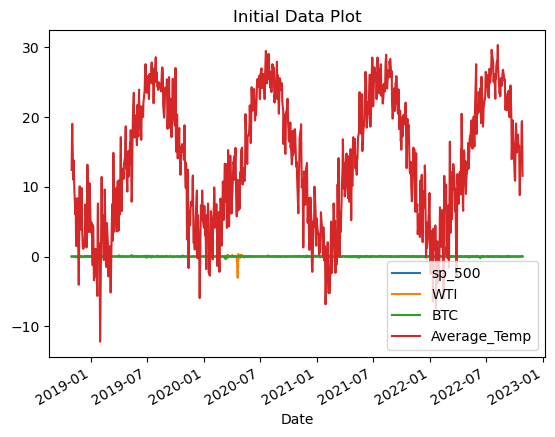

In [3]:
# Create and view initial plot
combined_df.plot(title="Initial Data Plot")

### Assessment
NYC temperature obviously follows a predictable pattern over the course of 4 years
However the scale of daily returns is so small that its pretty challenging to observe any potential correletion.

When we rescale the daily retuns, it is still challenging to observe any relationships.


In [ ]:
# Insert rescaled plot with daily_returns * 100+

### If we isolate the S&P 500 and average temperature, what relationship do we observe?

Text(0, 0.5, 'Average_Temp')

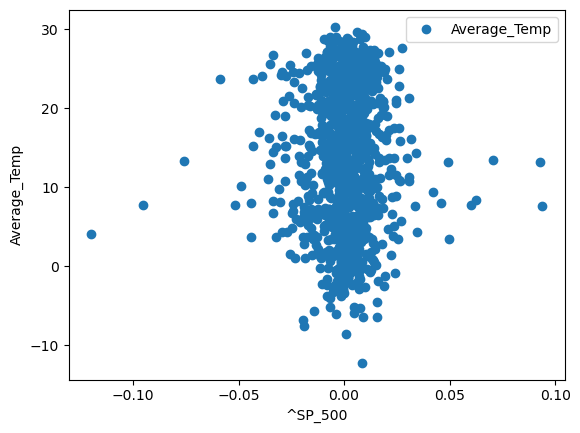

In [43]:
# Create and displays a plot 
combined_df.plot(x='sp_500', y= 'Average_Temp', style= 'o')
plt.xlabel ('^SP_500')
plt.ylabel ('Average_Temp')

### What does this graph tell us about the market performance / temperature correlation?
Since it may be hard to intuitively grasp the relationship, we also created a heatmap below to convey a quantified visual correlation.

<AxesSubplot:>

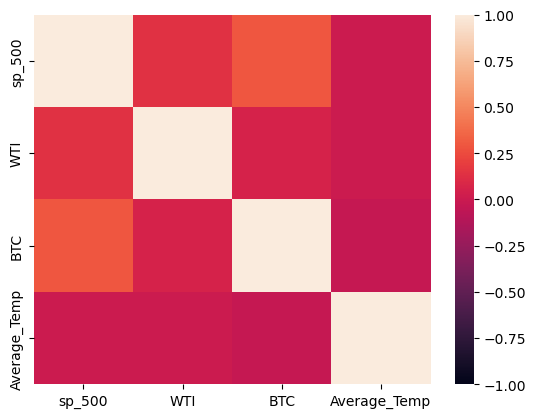

In [44]:
# Calculate and display de correlation matrix
correlation = combined_df.corr()
sns.heatmap(correlation, vmin=-1, vmax=1)

### Heatmap Analysis
The above heatmap shows show quantifiable figures indicating that weather is almost completely uncorrelated with the market as well as oil and BTC as specific assets.


## Question: Which of the factors in our initial data set is most correlated with the S&p 500?
The only observable correlations accoding to the heatmap is between the S&P 500 and BTC-USD. 
- Depending on the timeframe, we can see clear correlations by zooming in. For example, if we zoom into October 2022 the relationship is easy to observe.

In [8]:
# Removes the oil column
sp500_btc_comparision = combined_df.drop(columns=['WTI'])

# Plots and displays the data 
sp500_btc_comparision.hvplot.line(
    x='Date',
    y=['sp_500', 'BTC'],
    xlabel='Date',
    ylabel="Daily Return",
    title="BTC / S&P 500 Comparison"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# Sentiment Analysis
### Does a relationship exist between the overall market performance and the sentiment of people's Google searches?
In order to answer this question we collected market data from a specific time period and google search trend data (using `pytrends` external library) from the same period, then ran a correlation analysis.

### Function created for reusability
`from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2`

Note: These functions look at the absolute price of the asset.

SPY:2022-09-01 2022-09-30
SPY:2022-10-01 2022-10-31
SPY:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

(None, None)

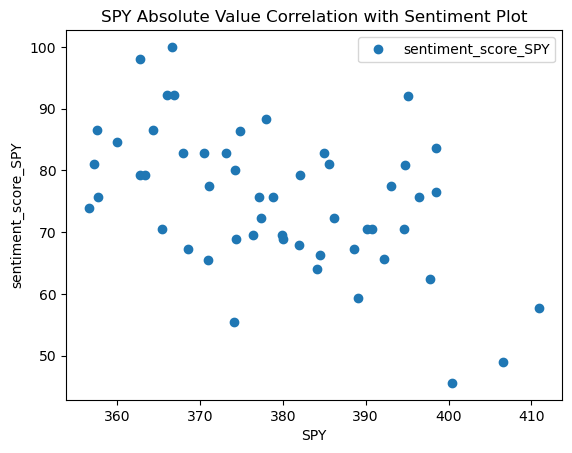

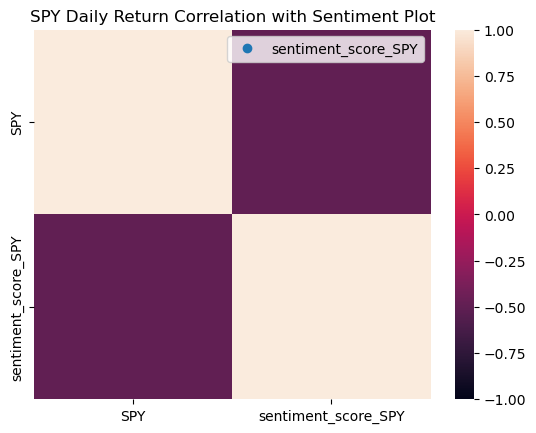

In [19]:
# S&P 500 index fund price plot with Google Trends sentiment score
generate_trends_analysis2('SPY')

BTC-USD:2022-09-01 2022-09-30
BTC-USD:2022-10-01 2022-10-31
BTC-USD:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

(None, None)

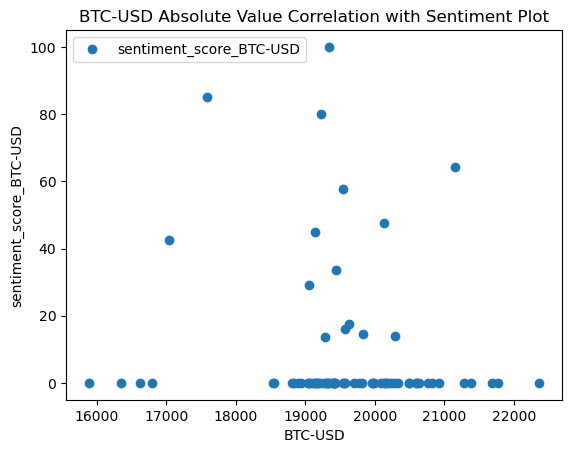

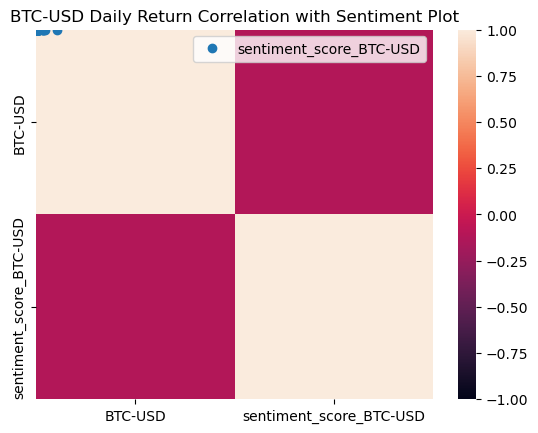

In [47]:
# Bitcoin price plot with Google Trends sentiment score
generate_trends_analysis2('BTC-USD')

CL=F:2022-09-01 2022-09-30
CL=F:2022-10-01 2022-10-31
CL=F:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'CL=F Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'CL=F Daily Return Correlation with Sentiment Plot'}>

(None, None)

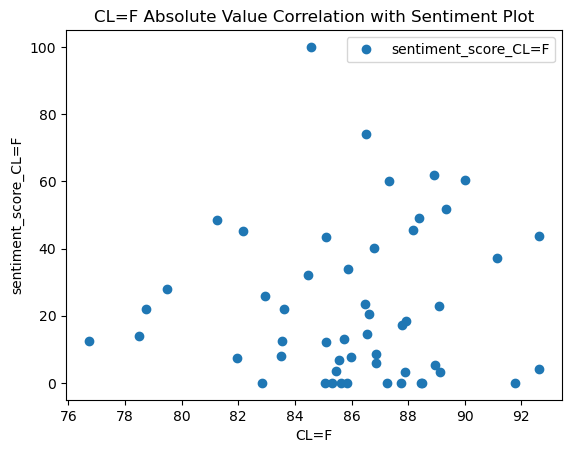

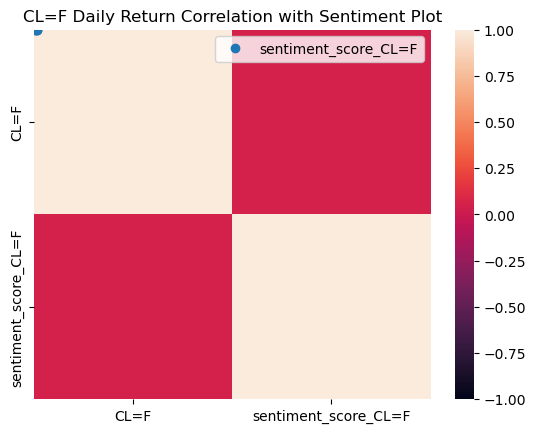

In [48]:
# Oil ETF price plot with Google Trends sentiment score
generate_trends_analysis2("CL=F")

# Analyis
- S&P 500: negatively correlated
- BTC: slightly negative
- Oil: neutral

## Additional Questions on Sentiment Analysis for forther investigatoin
- Our current analysis looks at the correlation between a given day's searches and the same day's asset value. If we were to stagger the days, would we see a deeper correlation?
- Since our analysis just looked at volume of searches, could a deeper look into what is being said reveal a deeper correlation? This would require a more sophisticated code that is able to perform NLP.
- Are there other search terms that correlate with the overall market performance or a specific asset's performance?

### Additional Trend Analysis demo
`trend_analysis_expanded(ticker, search_query)`

In [18]:
# Displays correlations graphs for a variety of relationships

# Ukrainian War
# trend_analysis_expanded("SPY", "ukrainian war")
# trend_analysis_expanded("SPY", "russia")
# trend_analysis_expanded("SPY", "Vladimir Putin")
# trend_analysis_expanded("SPY", "Volodymyr Zelenskyy")

# Game Stop
# trend_analysis_expanded("GME", "game stop")

# Portfolio Analysis
### Question: Would a portfolio made up of SP500 index fund, BTC and Oil perform well over time?
An analysis of the the S&P 500, BTC, and WTI tells us that these three are have a low correlation. And generally when creating a portfolio, having uncorrelated assets is good. But we would want to know more about relative risk and potential return before investing.

To dive deeper into this question, we started with looking at:
- Cumulative returns
- Measures of risk including: 1) standard deviation, 2) bet, 3) sharpe ratios

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

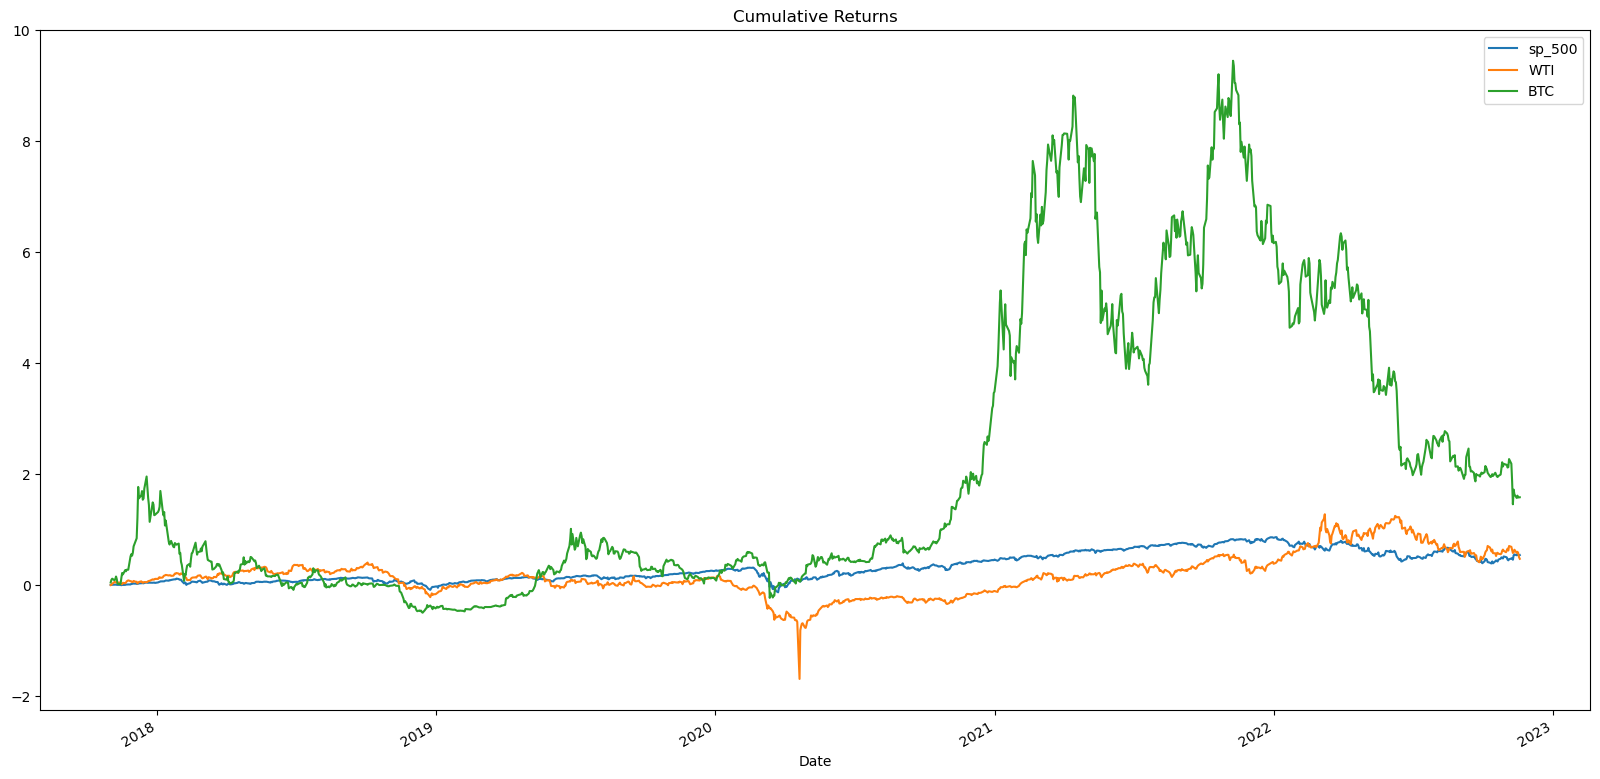

In [25]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + daily_returns).cumprod() - 1
# Plot cumulative returns
cumulative_returns.plot(
    title="Cumulative Returns",
    figsize=(20,10)
)

### Measures of Risk
- Volitility

In [21]:
# Callculate the daily standard deviations as a measure of risk
assets_std = daily_returns.std().sort_values()
assets_std

sp_500    0.013598
BTC       0.047636
WTI       0.098877
dtype: float64

<AxesSubplot:>

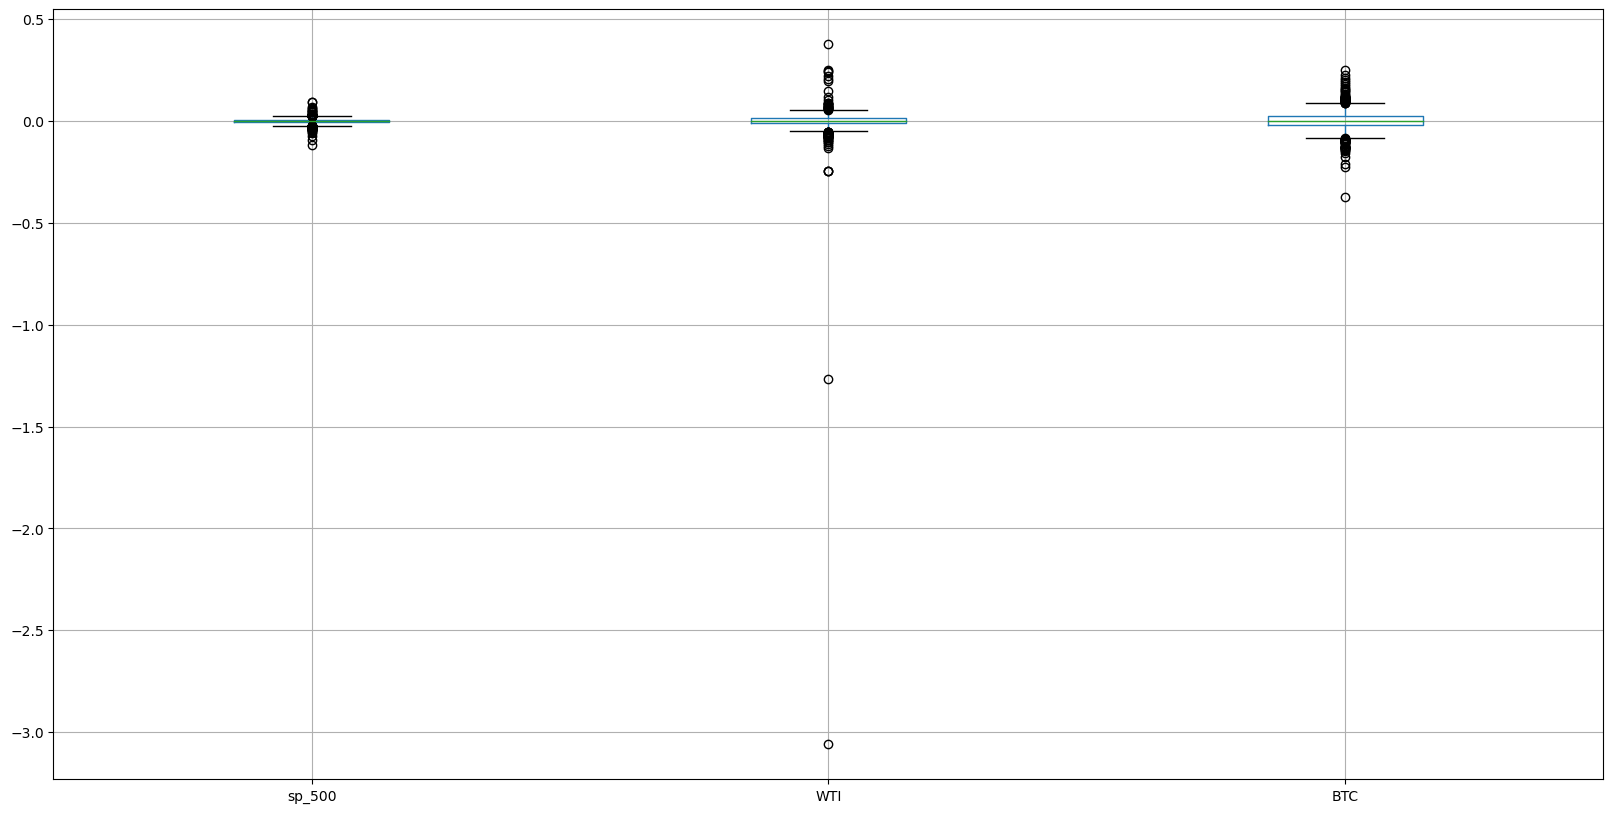

In [51]:
# Box plot to visually show risk
daily_returns.boxplot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

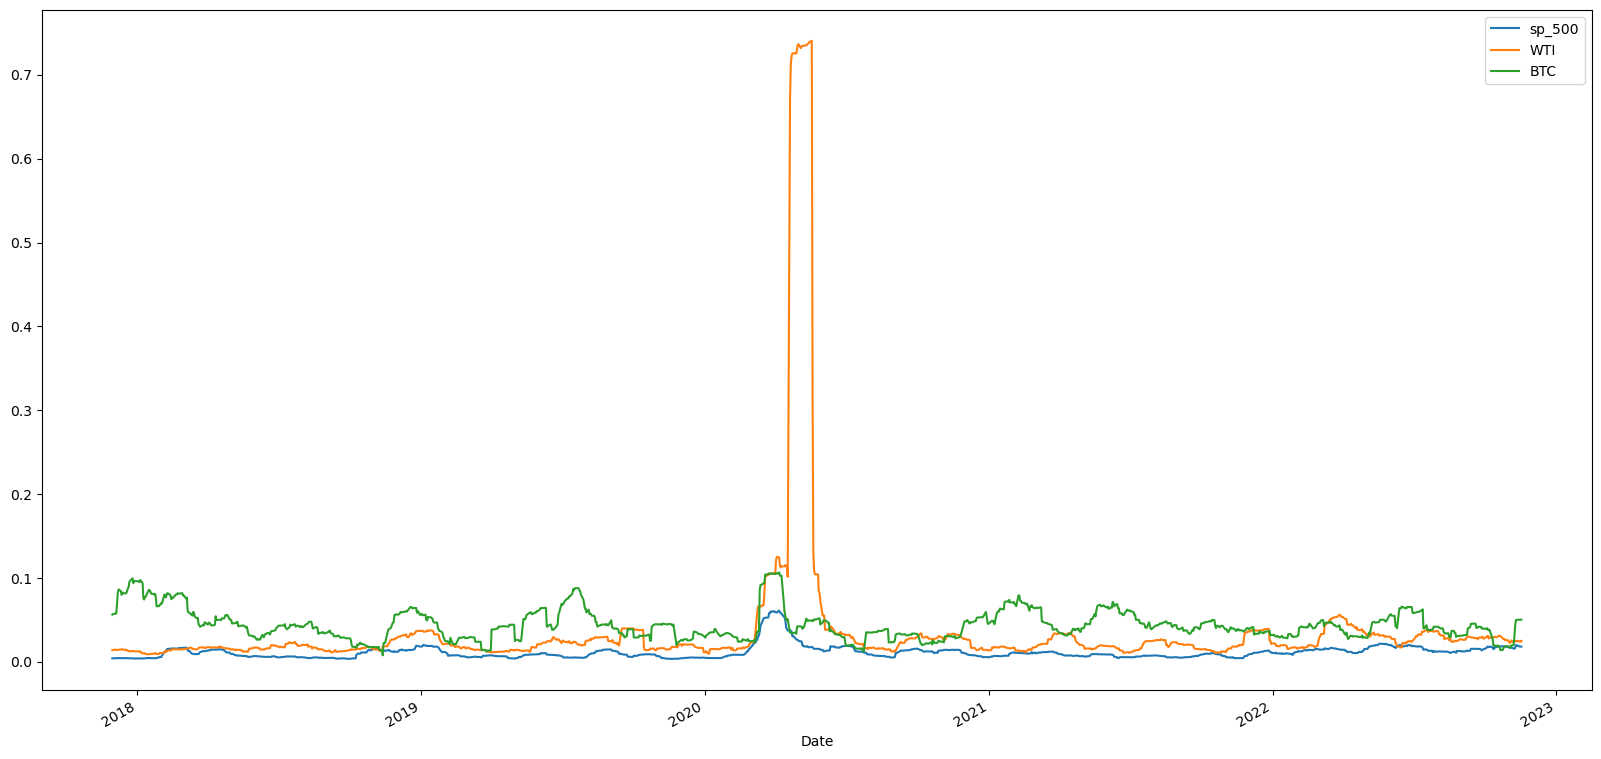

In [52]:
# callculate the rolling statandard deviation for 
rolling_21day_std_df = daily_returns.rolling(window=21).std()
# Plot the rolling standard deviation
rolling_21day_std_df.plot(figsize=(20,10))

### Beta tells us the risk relative to the overall market. 
- Calculated by dividing the covariance of an asset by the variance of the overall market."

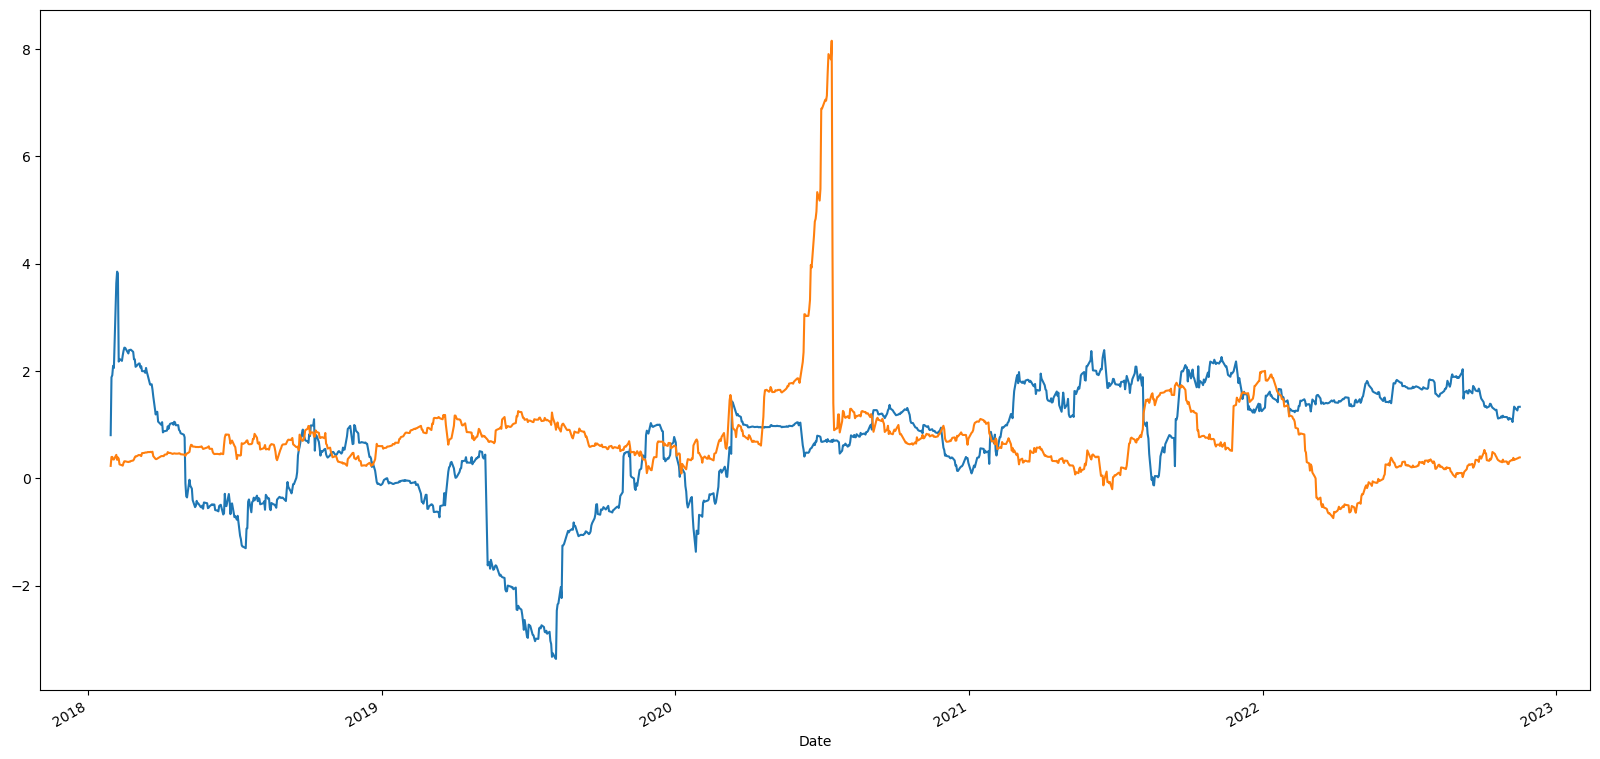

In [53]:
# Calculate covariance of a BTC
BTC_covariance = daily_returns["BTC"].rolling(window=60).cov(daily_returns["sp_500"])

# Calculate variance of S&P 500
variance = daily_returns["sp_500"].rolling(window=60).var()
# Computing beta
BTC_beta = BTC_covariance/variance
# Plot beta trend
BTC_plot = BTC_beta.plot(figsize=(20, 10))

# Calculate covariance of a WTI
WTI_covariance = daily_returns["WTI"].rolling(window=60).cov(daily_returns["sp_500"])
# Computing beta
WTI_beta = WTI_covariance/variance
# Plot beta trend
WTI_plot = WTI_beta.plot(figsize=(20, 10))

# Note BTC is in Blue and Oil is in Orange


### Sharpe Ratio
- Tells the reward relative to the risk compared the risk free rate

<AxesSubplot:title={'center':'Sharpe Ratios'}>

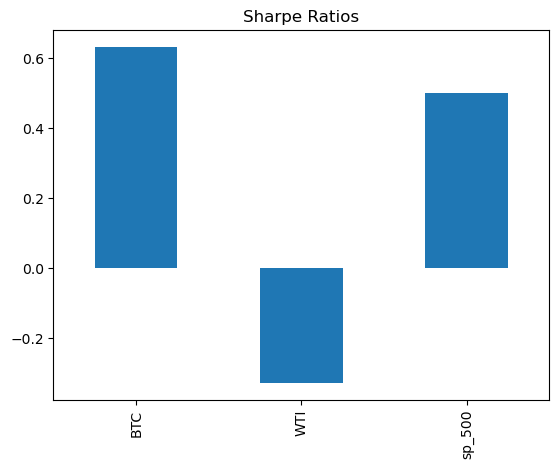

In [54]:
# Annualized Sharpe Ratios
sharpe_ratios = (daily_returns.mean() * 252) / (assets_std * np.sqrt(252))

# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

# Analysis

The S&P 500 has the least volitility as it is representative of the overall market performance. While conventional wisdom says BTC would be the riskier assets, the WTI oil ETF experienced a huge dip in the first half of 2020 (likely from the COVID-19 pandemic). As a reslut, oil ranks higher in volitilty than BTC.

`assets_std = daily_returns.std().sort_values()`

`sp_500    0.013608`

`BTC       0.047675`

`WTI       0.098946`

The Sharpe Ratios indicate that BTC has the highest upside. And despite it's high volitility, the reward outweighs the risk and it outperforms the market/S&P 500 on this metric. Oil on the other hand does not seem like a good asset to keep in the portfolio because 1) it has the highest volitily, 2)

## Question Restated: Would a portfolio made up of SP500 index fund, BTC and Oil be balanced and perform well over time?
Answer: Given the relative level that these assets are uncorrelated, combining them together in a portfolio could be a viable investment strategy. But to better answer this, we would need to run Monte Carlos Simulations.

# Future analysis
Markowitz to determine ideal ratio of the assets in a portfolio

# Summary
- No correlation with market performance and weather
- Some assets' performance correlate with Google Trends sentiment scores, but not reliable indicator of performance
- Portfolio recommend or no?

# END

... note: Unless we get the Monte Carlos simulation working, we can probably delete everything below here

In [55]:
combined_df


,sp_500,WTI,BTC,Average_Temp
Date,,,,
2018-10-31,0.010851,-0.013146,-0.002630,12.40
2018-11-01,0.010558,-0.024805,0.009524,16.60
2018-11-02,-0.006317,-0.008636,0.001671,19.00
2018-11-05,0.005600,-0.000634,0.004887,11.00
2018-11-06,0.006259,-0.014105,0.006441,12.95
...,...,...,...,...
2022-10-24,0.011882,-0.005526,0.009029,14.75
2022-10-25,0.016267,0.008749,0.038783,18.80
2022-10-26,-0.007388,0.030356,0.033568,19.40


In [56]:
# Insert Monete Carlos Simulation
asset_df = combined_df.drop(columns=['Average_Temp'])
asset_df

,sp_500,WTI,BTC
Date,,,
2018-10-31,0.010851,-0.013146,-0.002630
2018-11-01,0.010558,-0.024805,0.009524
2018-11-02,-0.006317,-0.008636,0.001671
2018-11-05,0.005600,-0.000634,0.004887
2018-11-06,0.006259,-0.014105,0.006441
...,...,...,...
2022-10-24,0.011882,-0.005526,0.009029
2022-10-25,0.016267,0.008749,0.038783
2022-10-26,-0.007388,0.030356,0.033568


In [57]:
MC_thirty_year = MCSimulation(
   portfolio_data = asset_df,
   weights = [1/3, 1/3, 1/3],
   num_simulation = 500,
   num_trading_days = 252*4
)

IndexError: Too many levels: Index has only 1 level, not 2

In [ ]:
calc_cumulative_return

In [ ]:
plot_simulation